In [1]:
import torch
import torchvision
import fastai
import os
import pandas as pd
import shutil
import random
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from PIL import Image
import pydicom
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
csv_path = '/kaggle/input/iaaa-mri-challenge/train.csv'
df = pd.read_csv(csv_path)
df.head()

,SeriesInstanceUID,prediction
0,1.3.46.670589.11.10042.5.0.6048.20240307143704...,0
1,1.3.46.670589.11.10042.5.0.6048.20240307143746...,0
2,1.3.46.670589.11.10042.5.0.6048.20240307143846...,0
3,1.3.46.670589.11.10042.5.0.4776.20240217030800...,0
4,1.3.46.670589.11.10042.5.0.4776.20240217030846...,0


In [3]:
os.mkdir('/kaggle/working/separated_data')


In [4]:
separated_data_folder = '/kaggle/working/separated_data'
data_folder = '/kaggle/input/iaaa-mri-challenge/data'

normal_folder = os.path.join(separated_data_folder, 'normal')
abnormal_folder = os.path.join(separated_data_folder, 'abnormal')

os.makedirs(normal_folder, exist_ok=True)
os.makedirs(abnormal_folder, exist_ok=True)

# Iterate through the CSV file and move folders
for index, row in df.iterrows():
    series_uid = row['SeriesInstanceUID']
    prediction = row['prediction']
    
    # Determine the source and destination paths
    src_folder = os.path.join(data_folder, series_uid)
    if prediction == 0:
        dst_folder = os.path.join(normal_folder, series_uid)
    else:
        dst_folder = os.path.join(abnormal_folder, series_uid)
    
    # Move the folder
    if os.path.exists(src_folder):
        shutil.copytree(src_folder, dst_folder)
    else:
        print(f"Folder {src_folder} does not exist")

print("Folders separated successfully!")

Folders separated successfully!


In [5]:
os.mkdir('/kaggle/working/splited_dataset')

In [6]:
# Paths to the normal and abnormal folders

base_folder = '/kaggle/working/splited_dataset'

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create directories for train, val, and test sets
train_folder = os.path.join(base_folder, 'train')
val_folder = os.path.join(base_folder, 'val')
test_folder = os.path.join(base_folder, 'test')

for subset in ['train', 'val', 'test']:
    os.makedirs(os.path.join(train_folder, 'normal'), exist_ok=True)
    os.makedirs(os.path.join(train_folder, 'abnormal'), exist_ok=True)
    os.makedirs(os.path.join(val_folder, 'normal'), exist_ok=True)
    os.makedirs(os.path.join(val_folder, 'abnormal'), exist_ok=True)
    os.makedirs(os.path.join(test_folder, 'normal'), exist_ok=True)
    os.makedirs(os.path.join(test_folder, 'abnormal'), exist_ok=True)

# Function to split and move folders
def split_and_move_folders(src_folder, dst_base_folder):
    folders = [f for f in os.listdir(src_folder) if os.path.isdir(os.path.join(src_folder, f))]
    random.shuffle(folders)
    
    train_count = int(len(folders) * train_ratio)
    val_count = int(len(folders) * val_ratio)
    test_count = len(folders) - train_count - val_count
    
    splits = {
        'train': folders[:train_count],
        'val': folders[train_count:train_count + val_count],
        'test': folders[train_count + val_count:]
    }
    
    for split, split_folders in splits.items():
        for folder in split_folders:
            src_path = os.path.join(src_folder, folder)
            dst_path = os.path.join(dst_base_folder, split, os.path.basename(src_folder), folder)
            shutil.move(src_path, dst_path)

# Split and move normal and abnormal folders
split_and_move_folders(normal_folder, base_folder)
split_and_move_folders(abnormal_folder, base_folder)

print("Data split into train, val, and test sets successfully!")

Data split into train, val, and test sets successfully!


In [ ]:
output_folder = '/kaggle/working/final_data'

# Create output directories for train, val, and test sets
for subset in ['train', 'val', 'test']:
    for category in ['normal', 'abnormal']:
        os.makedirs(os.path.join(output_folder, subset, category), exist_ok=True)

def process_and_save_dicom(src_folder, dst_folder):
    for root, _, files in os.walk(src_folder):
        for file in files:
            if file.endswith(".dcm"):
                dicom_path = os.path.join(root, file)
                dicom_data = pydicom.dcmread(dicom_path)
                pixel_array = dicom_data.pixel_array
                protocol_name = dicom_data.ProtocolName.replace(" ", "_")  # Remove spaces in description
                save_path = os.path.join(dst_folder, f"{os.path.splitext(file)[0]}_{protocol_name}.npy")
                np.save(save_path, pixel_array)

# Process and save DICOM files in train, val, and test sets
for subset in ['train', 'val', 'test']:
    for category in ['normal', 'abnormal']:
        src_folder = os.path.join(base_folder, subset, category)
        dst_folder = os.path.join(output_folder, subset, category)
        process_and_save_dicom(src_folder, dst_folder)

print("DICOM files processed and saved as NumPy arrays with SeriesDescription in filenames.")

In [19]:
IMG_WIDTH = 128 
IMG_HEIGHT = 128
class CustomDataset(Dataset):
    def __init__(self, input_folder, transform=None):
        self.images = []
        self.labels = []
        self.transform = transform
        class_folders = sorted(os.listdir(input_folder))

        for class_idx, class_folder in enumerate(class_folders):
            class_path = os.path.join(input_folder, class_folder)
            if os.path.isdir(class_path):
                npy_files = [file for file in os.listdir(class_path) if file.endswith('.npy')   and 'T2W_FLAIR' in file]
                for npy_file in npy_files:
                    slice_data = np.load(os.path.join(class_path, npy_file))

                    # Ensure slice_data has three dimensions
                    if len(slice_data.shape) == 2:
                        slice_data = np.expand_dims(slice_data, axis=-1)

                    # Ensure slice_data is of shape (IMG_HEIGHT, IMG_WIDTH, channels)
                    if slice_data.shape[0] != IMG_HEIGHT or slice_data.shape[1] != IMG_WIDTH:
                        slice_data = np.squeeze(slice_data, axis=-1)
                        slice_data = Image.fromarray(slice_data.astype(np.float32))
                        slice_data = slice_data.resize((IMG_WIDTH, IMG_HEIGHT))
                        slice_data = np.array(slice_data)

                    self.images.append(slice_data)
                    self.labels.append(class_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transform
transform = transforms.Compose([
    transforms.ToTensor()
])

In [20]:
# Load datasets
input_train_folder = '/kaggle/working/final_data/train'
train_dataset = CustomDataset(input_folder=input_train_folder, transform=transform)
input_val_folder = '/kaggle/working/final_data/val'
val_dataset = CustomDataset(input_folder=input_val_folder, transform=transform)
input_test_folder = '/kaggle/working/final_data/test'
test_dataset = CustomDataset(input_folder=input_test_folder, transform=transform)

In [21]:
 #Calculate class weights
class_counts = np.bincount(train_dataset.labels)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum() * len(class_weights)

samples_weights = np.array([class_weights[label] for label in train_dataset.labels])
sampler = WeightedRandomSampler(samples_weights, num_samples=len(samples_weights), replacement=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check if a GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
samples_weights.shape

(36603,)

In [24]:
def show_random_slices(data_loader, num_slices=5):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))
    for i in range(num_slices):
        idx = np.random.randint(0, len(images))
        image = images[idx].numpy().transpose((1, 2, 0))
        label = labels[idx].item()
        
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    
    plt.show()

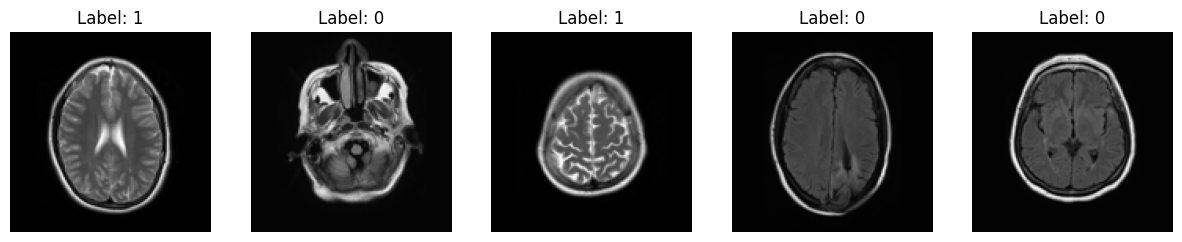

In [27]:
show_random_slices(train_loader, 5)

In [28]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional block
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third convolutional block
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Flatten and Dense layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=128*16*16, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        # First convolutional block
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        
        # Second convolutional block
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        
        # Third convolutional block
        x = F.relu(self.conv4(x))
        x = self.pool3(x)
        
        # Flatten and Dense layers
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        
        return x

In [29]:
model = CNNModel()

# Check if a GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Calculate class weights
class_counts = np.bincount(train_dataset.labels)
class_weights = 1. / class_counts
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define the loss function with class weights
criterion = nn.BCELoss() 

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

In [32]:
num_epochs = 50  # Set the number of epochs

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        outputs = outputs.squeeze()  # Remove the single-dimensional entry for BCEWithLogitsLoss
        labels = labels.float()  # Ensure labels are of type float for BCEWithLogitsLoss
        
        # Compute loss
        
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    # Validation step
    torch.save(model.state_dict(), '/kaggle/working/model_t1_test1.pth')
    model.eval()
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        val_loss = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.squeeze()  # Remove the single-dimensional entry for BCEWithLogitsLoss
            labels = labels.float()  # Ensure labels are of type float for BCEWithLogitsLoss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())
    
    # Calculate precision, recall, and AUC
    all_outputs = np.array(all_outputs)
    all_labels = np.array(all_labels)
    predicted_labels = (all_outputs > 0.5).astype(int)
    
    precision = precision_score(all_labels, predicted_labels)
    recall = recall_score(all_labels, predicted_labels)
    auc = roc_auc_score(all_labels, all_outputs)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss/len(val_loader):.4f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}')

# Example testing loop
model.eval()
all_test_labels = []
all_test_outputs = []
with torch.no_grad():
    test_loss = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        outputs = outputs.squeeze()  # Remove the single-dimensional entry for BCEWithLogitsLoss
        labels = labels.float()  # Ensure labels are of type float for BCEWithLogitsLoss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        all_test_labels.extend(labels.cpu().numpy())
        all_test_outputs.extend(outputs.cpu().numpy())

all_test_outputs = np.array(all_test_outputs)
all_test_labels = np.array(all_test_labels)
predicted_test_labels = (all_test_outputs > 0.5).astype(int)

test_precision = precision_score(all_test_labels, predicted_test_labels)
test_recall = recall_score(all_test_labels, predicted_test_labels)
test_auc = roc_auc_score(all_test_labels, all_test_outputs)

print(f'Test Loss: {test_loss/len(test_loader):.4f}')
print(f'Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test AUC: {test_auc:.4f}')

Epoch [1/70], Loss: 0.3647, Val Loss: 0.4955
Precision: 0.9211, Recall: 0.8350, AUC: 0.7294
Epoch [2/70], Loss: 0.1870, Val Loss: 0.6494
Precision: 0.9238, Recall: 0.8652, AUC: 0.7405
Epoch [3/70], Loss: 0.6960, Val Loss: 0.7439
Precision: 0.9247, Recall: 0.8607, AUC: 0.7521
Epoch [4/70], Loss: 0.2131, Val Loss: 1.1637
Precision: 0.9219, Recall: 0.9077, AUC: 0.7413
Epoch [5/70], Loss: 0.4869, Val Loss: 1.8046
Precision: 0.9095, Recall: 0.9590, AUC: 0.7542
Epoch [6/70], Loss: 0.8227, Val Loss: 1.4039
Precision: 0.9262, Recall: 0.9325, AUC: 0.7795
Epoch [7/70], Loss: 1.1507, Val Loss: 1.8933
Precision: 0.9270, Recall: 0.9085, AUC: 0.7679
Epoch [8/70], Loss: 0.4996, Val Loss: 1.6666
Precision: 0.9204, Recall: 0.9536, AUC: 0.7748
Epoch [9/70], Loss: 0.0145, Val Loss: 1.9580
Precision: 0.9197, Recall: 0.9494, AUC: 0.7655
Epoch [10/70], Loss: 8.1236, Val Loss: 2.4186
Precision: 0.9167, Recall: 0.9586, AUC: 0.7647
Epoch [11/70], Loss: 0.2974, Val Loss: 2.2281
Precision: 0.9232, Recall: 0.9391